In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import imageio

import os
import dill
import sys
sys.path.append('../../')

In [2]:
#.manual_seed(1)    # reproducible
real_data=True
dt=1e-2
if real_data:
    n = 4
    sys_name = 'analytic_koop_sys'
    directory = os.path.abspath("")                                     # Path to save learned models
    infile = open(directory + '/data/' + sys_name + '_data.pickle', 'rb')
    xs_train, t_train, n_traj_train, xs_val, t_val, n_traj_val = dill.load(infile)
    infile.close()
    
    xs = xs_train[:,:-1,:]
    xs_prime = xs_train[:,1:,:]
    order = 'F'
    n_data_pts = n_traj_train * (xs.shape[1])
    x_flat = xs.T.reshape((n, n_data_pts), order=order)
    x_prime_flat = xs_prime.T.reshape((n, n_data_pts), order=order)

    x = x_flat.T
    y = x_prime_flat.T - x
    x, y = x[:,2:], y[:,2:]
    X = np.concatenate((x, x+y), axis=1)
    X, y = torch.Tensor(X), torch.Tensor(y)
    
else:
    mu, lambd = -0.3, -0.6
    min_x = [-1., -1.]
    max_x = [1., 1.]
    n_pts = 500
    x = torch.Tensor(np.random.uniform(min_x, max_x, (n_pts,2)))  # x data (tensor), shape=(100, 1)
    y = dt*torch.cat((mu*x[:,0].reshape(-1,1), (-lambd*x[:,0].pow(2) + lambd*x[:,1]).reshape(-1,1)), 1)# + dt*0.2*torch.rand(x.size())                 # noisy y data (tensor), shape=(100, 1)
    X = torch.cat((x, x+y),1)

# torch can only train on Variable, so convert them to Variable
X, y = Variable(X), Variable(y)

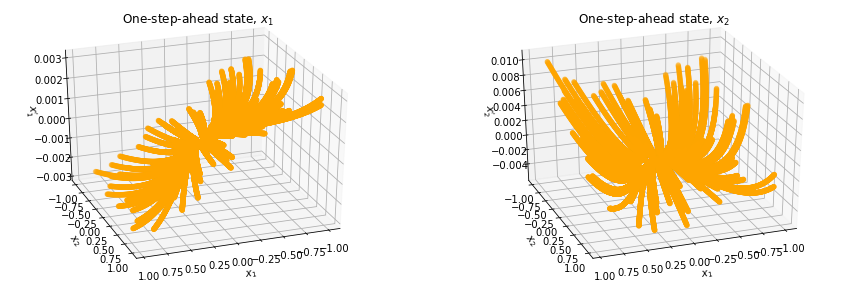

In [3]:
# view data
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X[:,0].data.numpy(), X[:,1].data.numpy(), y[:,0].data.numpy(), color = "orange")
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel("$x_1'$")
ax.set_title('One-step-ahead state, $x_1$')
ax.view_init(30, 70)

ax = fig.add_subplot(122, projection='3d')
ax.scatter(X[:,0].data.numpy(), X[:,1].data.numpy(), y[:,1].data.numpy(), color = "orange")
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel("$x_2'$")
ax.set_title('One-step-ahead state, $x_2$')
ax.view_init(30, 70)

plt.show()

In [4]:
from koopman_core.learning import KoopmanNetAut
from torch import optim

net_params = {}
net_params['state_dim'] = 2
net_params['encoder_hidden_width'] = 100
net_params['encoder_hidden_depth'] = 1
net_params['encoder_output_dim'] = 1
net_params['optimizer'] = 'adam'
net_params['lr'] = 1e-2
net_params['epochs'] = 100
net_params['batch_size'] = 128
net_params['lin_loss_penalty'] = 0.5
net_params['l2_reg'] = 0
net_params['l1_reg'] = 0
net_params['n_multistep'] = 1
net_params['first_obs_const'] = False
net_params['override_kinematics'] = False
net_params['dt'] = dt

#standardizer_kdnn = preprocessing.StandardScaler(with_mean=False)
standardizer_kdnn = None

net = KoopmanNetAut(net_params, standardizer=standardizer_kdnn)
net.construct_net()
optimizer = optim.Adam(net.optimization_parameters, lr=net_params['lr'], weight_decay=net_params['l2_reg'])

In [5]:
import torch

dataset_train = torch.utils.data.TensorDataset(X, y)
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=net_params['batch_size'], shuffle=True, num_workers=0, pin_memory=True)

Epoch:  0 , loss:  0.00022018669
Epoch:  1 , loss:  4.4952038e-05
Epoch:  2 , loss:  6.2751875e-05
Epoch:  3 , loss:  3.6311256e-05
Epoch:  4 , loss:  2.07353e-05
Epoch:  5 , loss:  0.0001072779
Epoch:  6 , loss:  2.0124553e-05
Epoch:  7 , loss:  1.8589186e-05
Epoch:  8 , loss:  1.5481506e-05
Epoch:  9 , loss:  1.3580908e-05
Epoch:  10 , loss:  1.1850785e-05
Epoch:  11 , loss:  1.7028964e-05
Epoch:  12 , loss:  2.5658772e-05
Epoch:  13 , loss:  1.1503035e-05
Epoch:  14 , loss:  1.9479729e-05
Epoch:  15 , loss:  2.3083965e-05
Epoch:  16 , loss:  2.6775122e-05
Epoch:  17 , loss:  4.581441e-05
Epoch:  18 , loss:  7.823846e-06
Epoch:  19 , loss:  1.6108934e-05
Epoch:  20 , loss:  1.3097699e-05
Epoch:  21 , loss:  5.0495633e-05
Epoch:  22 , loss:  3.363143e-05
Epoch:  23 , loss:  2.5207772e-05
Epoch:  24 , loss:  2.4101704e-05
Epoch:  25 , loss:  2.041793e-05
Epoch:  26 , loss:  6.497267e-06
Epoch:  27 , loss:  1.3495295e-05
Epoch:  28 , loss:  1.4242239e-05
Epoch:  29 , loss:  1.3674855e-0

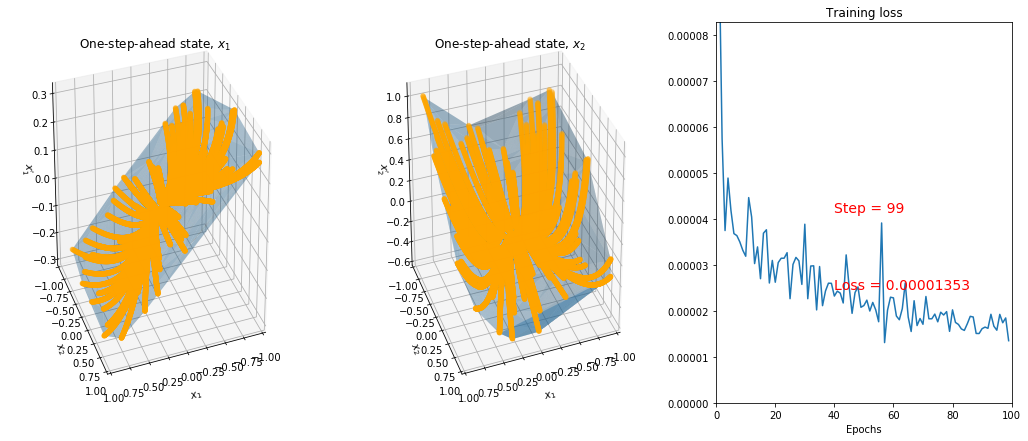

In [6]:
my_images = []
fig = plt.figure(figsize=(18,7))
ax = [fig.add_subplot(131, projection='3d'), fig.add_subplot(132, projection='3d'), fig.add_subplot(133)]
loss_hist = []

# train the network
n_epochs = net_params['epochs']
for t in range(n_epochs):
    running_loss = 0.0
    epoch_steps = 0
    
    for data in trainloader:
        inputs, labels = data
  
        prediction = net(inputs)     # input x and predict based on x

        loss = net.loss(prediction, labels)     # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
        
        running_loss += loss.detach()
        epoch_steps += 1
    
    loss_hist.append(running_loss/epoch_steps)
    
    # plot and show learning process
    prediction = net(X)
    for ii in range(2):
        ax[ii].cla()
        ax[ii].set_xlim(-1, 1)
        ax[ii].set_ylim(-1, 1)
        #ax[ii].set_zlim(-0.02, 0.02)
        ax[ii].scatter(X[:,0].data.numpy(), X[:,1].data.numpy(), y[:,ii].data.numpy()/dt, color = "orange")
        ax[ii].plot_trisurf(X[:,0].data.numpy(), X[:,1].data.numpy(), prediction[:,ii].data.numpy(), alpha=0.4, shade=True)
        ax[ii].set_xlabel('$x_1$')
        ax[ii].set_ylabel('$x_2$')
        ax[ii].set_zlabel('$x_' + str(ii+1) + "'$")
        ax[ii].set_title('One-step-ahead state, $x_' + str(ii+1) + '$')
        ax[ii].view_init(30, 70)

    hist_index = max(0, t - 100)
    plot_max = 1.2*np.mean(loss_hist[hist_index:])
    ax[-1].cla()
    ax[-1].plot(range(len(loss_hist)), loss_hist)
    ax[-1].set_xlim(0, n_epochs)
    ax[-1].set_ylim(0, plot_max)
    ax[-1].set_title('Training loss')
    ax[-1].set_xlabel('Epochs')
    ax[-1].text(int(0.4*n_epochs), 0.5*plot_max, 'Step = %d' % t, fontdict={'size': 14, 'color':  'red'})
    ax[-1].text(int(0.4*n_epochs), 0.3*plot_max, 'Loss = %.8f' % loss_hist[-1],
                fontdict={'size': 14, 'color':  'red'})

    # Used to return the plot as an image array 
    # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    my_images.append(image)
    if t%1 == 0:
        print('Epoch: ', t, ', loss: ', loss.data.numpy())
    
# save images as a gif    
imageio.mimsave('figures/koop_simplified.gif', my_images, fps=10)